In [6]:
%pip install --quiet lightning

Note: you may need to restart the kernel to use updated packages.


### Define dataset class


Dataset downloaded from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation.

In [7]:
import os
import glob
import warnings
from natsort import natsorted

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

from PIL import Image

class BrainMRIDataset(Dataset):
    def __init__(self,
                 root_dir,
                 transform = None,
                 target_transform = None,
                ):

        self.transform = transform
        self.target_transform = target_transform

        # at the end of this function this array will contain ({image_path},{mask_path}) pairs
        self.image_mask_pairs = []
        

        # Scan folder structure and add all the images and masks

        
        patients_dirs = sorted([os.path.join(root_dir, entry) for entry in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, entry))])
        self.patients_offset = [0]*len(patients_dirs)

        offset = 0

        for patient_idx, patient in enumerate(patients_dirs):

            self.patients_offset[patient_idx] = offset

            images = [os.path.join(patient, entry) for entry in os.listdir(patient)]
            images = natsorted([img for img in images if "_mask" not in img])

            for img_path in images:
                    base_name = os.path.splitext(img_path)[0]
                    mask_path = base_name + "_mask.tif"
                    if not os.path.exists(mask_path):
                        warnings.warn(f"Image {img_path} is missing mask, skipping")
                    else:
                        self.image_mask_pairs.append((img_path, mask_path))
            
            offset = len(self.image_mask_pairs) - 1

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask
    
    def _get_patient_samples_indices(self, idx):
        if idx == len(self.patients_offset) - 1:
            end = len(self)
        else:
            end = self.patients_offset[idx+1]
        
        return list(range(self.patients_offset[idx],end))
    
    def get_patient_samples(self, idx):
        return [self[i] for i in self._get_patient_samples_indices(idx)]
    
    

    def num_patients(self):
        return len(self.patients_offset)


In [8]:
import torch
import torch.nn as nn

from torchvision import transforms

def overlay_mask(image, mask, color=(1.0, 0.0, 0.0), alpha=0.45, saturation=0.2):
    """
    Overlay a binary mask onto an image tensor.

    Parameters:
        image (torch.Tensor): Float tensor (3, H, W), values in [0, 1]
        mask (torch.Tensor): Binary tensor (1, H, W), values in {0, 1}
        color (tuple): RGB tuple in [0, 1], e.g., (1, 0, 0) for red
        alpha (float): Overlay transparency (0 = transparent, 1 = solid)
        saturation (float): factor in [0,1] of saturation adjustment applied to the image (0 = bw, 1 = untouched).

    Returns:
        torch.Tensor: New image tensor with overlay applied (3, H, W)
    """
    if image.ndim != 3 or image.shape[0] != 3:
        raise ValueError("Image must be a tensor of shape (3, H, W)")

    if mask.ndim != 3 or mask.shape[0] != 1:
        raise ValueError("Mask must be a tensor of shape (1, H, W)")


    if image.shape[1:] != mask.shape[1:]:
        raise ValueError(f"Spatial dimensions of mask must match dimensions of the image")

    # Convert image to grayscale if grey_scale is True
    if saturation < 1.0:
        image = F.adjust_saturation(image,saturation)

    if image.max() > 1:
        image = image / 255.0

    # Create color mask
    color_tensor = torch.tensor(color, dtype=image.dtype, device=image.device).view(3, 1, 1)
    mask = (mask > 0.5).float()  # Convert mask to binary values (0 or 1)

    # Blend color and image where mask == 1
    overlay = image * (1 - mask * alpha) + color_tensor * (mask * alpha)
    return overlay.clamp(0, 1)


### Initialize and Visualize Dataset

In [9]:
from torchvision import utils
import matplotlib.pyplot as plt

def show_samples(samples,title=None,saturation=0.2):

    samples_img = [overlay_mask(s[0],s[1],saturation=saturation) for s in samples]

    img = utils.make_grid(samples_img, min(len(samples_img),8))

    plt.figure(figsize = (10,10))
    if title:
        plt.title(title)
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


def show_pair(sample,title=None):
    img, mask = sample
    
    if title:
        plt.title(title)
        plt.axis('off')

    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Image')
    plt.imshow(img.permute(1,2,0))

    mask = mask.repeat(3,1,1)
    mask[1:] = 0

    plt.subplot(1,2,2)
    plt.title('Mask')
    plt.imshow(mask.permute(1,2,0))
    plt.axis('off')

    plt.tight_layout(pad=0)
    plt.show()


### Split data and define Dataloaders

We will use a PyTorch Lightning [DataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). This is not really needed, you can use plain data loaders if you prefer. The nice thing about this is that it encapsulate all the logic that deals with the data preparation.

In [10]:
from torch.utils.data import random_split, DataLoader
import lightning as L

class BrainMRIDataModule(L.LightningDataModule):
    def __init__(self, root_dir, batch_size=64, num_workers=0, split_ratio=(0.8, 0.1, 0.1)):
        super().__init__()
        self.root_dir = root_dir
        
        self.full_set = None

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.split_ratio = split_ratio

        if not torch.isclose(torch.tensor(sum(split_ratio)), torch.tensor(1.0)):
            raise ValueError(f"Split ratios must sum to 1.0, got sum={sum(split_ratio)}")

    def setup(self, stage=None):
        
        transform = transforms.Compose([
            transforms.ToTensor(),  # Converts image to tensor in [0, 1]
            transforms.Resize((128, 128)),
            transforms.Grayscale(3), # Optional, experiment with and without!
        ])

        self.full_set = BrainMRIDataset(self.root_dir,transform=transform,target_transform=transform)
        
        dataset_len = len(self.full_set)

        train_len = int(self.split_ratio[0] * dataset_len)
        val_len = int(self.split_ratio[1] * dataset_len)
        test_len = dataset_len - train_len - val_len

        self.train_set, self.val_set, self.test_set = random_split(
            self.full_set, [train_len, val_len, test_len]
        )

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


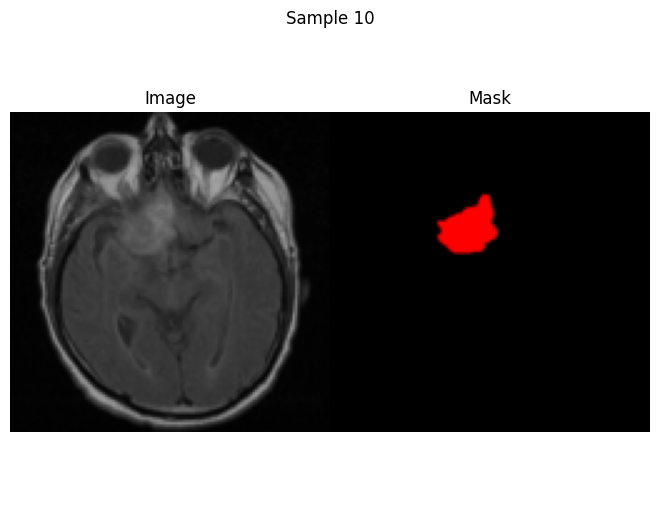

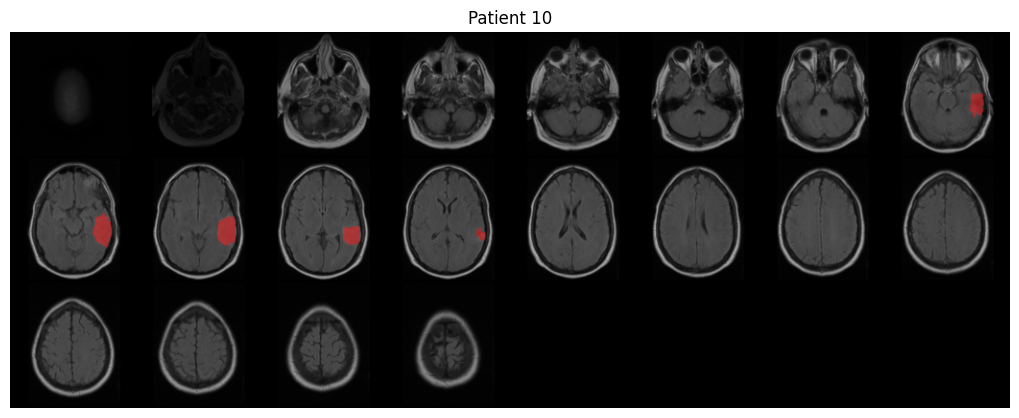

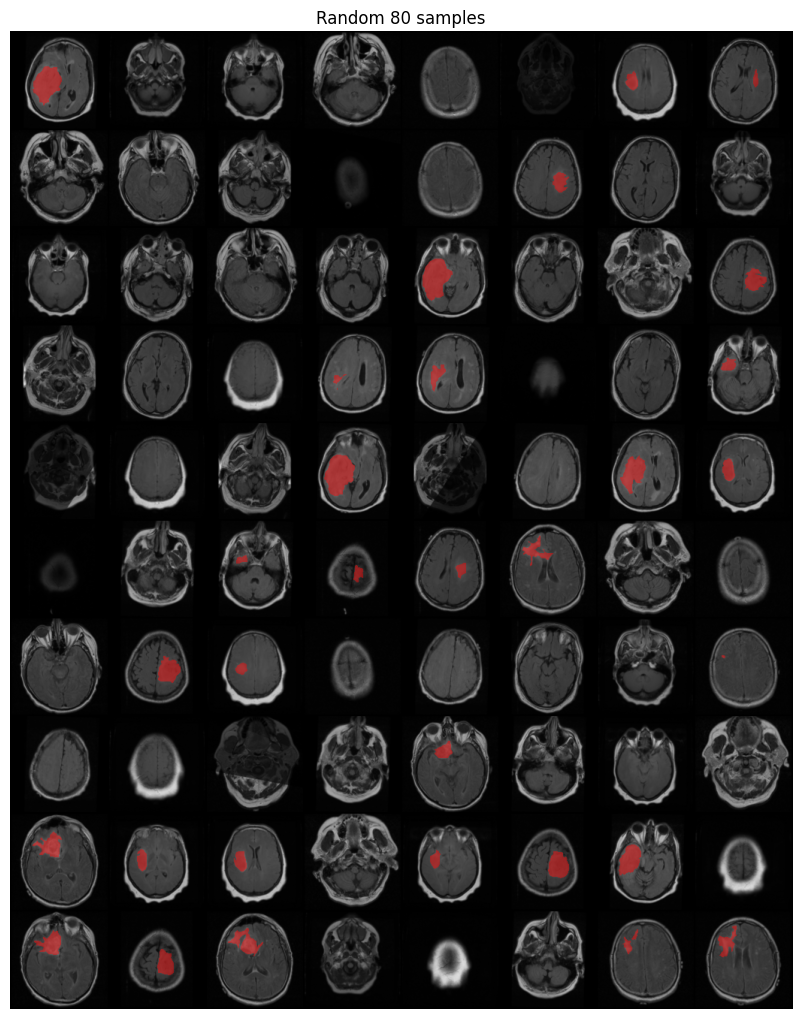

In [11]:

dm = BrainMRIDataModule('./data/lgg-mri-segmentation/kaggle_3m')

# The following is only for showing the samples, it is not mandatory

dm.setup()

ds = dm.full_set

# show a pair (img,mask)
idx = 10
show_pair(ds[idx],f'Sample {idx}')

# show samples for a patient
patient_idx = 10
show_samples(ds.get_patient_samples(patient_idx),f'Patient {patient_idx}')

# show first N samples
n_rand_samples = 80
show_samples([ds[i] for i in torch.randperm(n_rand_samples)],f'Random {n_rand_samples} samples',saturation=0)





## Define the Loss and Model

In [12]:
%pip install --quiet segmentation_models_pytorch

import segmentation_models_pytorch as smp

Note: you may need to restart the kernel to use updated packages.


/Users/marco/Dev/_ML/IVU_Tutorials/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the loss

Several metrics are useful in evaluating a segmentation model. Since a segmentation problem can be seen as a pixel-wise classification, `CrossEntropyLoss` (or in this case `BinaryCrossEntropyLoss`) can be used.
Another approach is to use geometric methods that measure, in some way, the overlap of the areas.

![](./images/dicevsiou.png)


Quick schema on which one to pick

| Scenario                        | Recommended Loss                     |
|----------------------------------|---------------------------------------|
| Balanced dataset                | CrossEntropy                          |
| Class imbalance (e.g., organs)  | Dice Loss         |
| Strict overlap quality needed   | IoU or Combo: Dice + IoU              |
| Multi-class segmentation        | CE or per-class Dice averaged         |

In [13]:
class SegmentationLoss(torch.nn.Module):
    def __init__(self,alpha=0.2):
        super().__init__()

        self.alpha = alpha

        self.bce_loss_fn = torch.nn.BCEWithLogitsLoss()
        self.dice_loss_fn = smp.losses.DiceLoss(mode='binary')

    def forward(self, logits, targets):
        loss = self.alpha*self.bce_loss_fn(logits,targets) + (1-self.alpha)*self.dice_loss_fn(logits,targets)
        return loss

**Exercise** Experiment further with these losses trying to tune the weights `alpha`.

### Construct the model

#### ResNet34

![ResNet34](./images/resnet34.jpg)


#### U-Net

![](./images/u-net-original.png)

![](./images/unet.png)

In [14]:

import torchvision.models as models

class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResNetUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        base_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.input_conv = nn.Sequential(
            base_model.conv1, base_model.bn1, base_model.relu
        )
        self.maxpool = base_model.maxpool
        self.encoder1 = base_model.layer1  # 64
        self.encoder2 = base_model.layer2  # 128
        self.encoder3 = base_model.layer3  # 256
        self.encoder4 = base_model.layer4  # 512

        self.center = ConvBlock(512, 512)

        self.decoder4 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 64, 32)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):

        x0 = self.input_conv(x)        # H/2
        x1 = self.maxpool(x0)          # H/4

        x2 = self.encoder1(x1)         # H/4
        x3 = self.encoder2(x2)         # H/8
        x4 = self.encoder3(x3)         # H/16
        x5 = self.encoder4(x4)         # H/32

        center = self.center(x5)

        d4 = self.decoder4(center, x4)
        d3 = self.decoder3(d4, x3)
        d2 = self.decoder2(d3, x2)
        d1 = self.decoder1(d2, x0)
        
        up = self.upsample(d1)
        out = self.final_conv(up)

        return out


**Exercise** It is possible to substitute the transposed convolution operation with upsampling followed by a "normal" convolution. In this case the "upscaling" part is not learned but fixed. Try to experiment with that.

### Define the Lightning Module (train/val/test steps)

In [15]:
class SegmentationModule(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters() # saves arguments passed to the constructor

        self.model = ResNetUNet(n_classes=1)
        # to load predefined smp.Unet
        #self.model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1, encoder_weights='imagenet')
        self.loss_fn = SegmentationLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_fn(y_hat,y)

        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_fn(y_hat,y)

        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_fn(y_hat,y)

        self.log("test_loss", loss)

### Train it and test it

In [16]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

model = SegmentationModule()

logger = TensorBoardLogger(save_dir="./logs")

trainer = L.Trainer(
    #fast_dev_run=True, # activate this when you just want to see if the code runs
    min_epochs=5,
    max_epochs=15,
    accelerator="mps",
    log_every_n_steps=5,
    #precision='16-mixed', # if your hardware supports it, you can use a different precision
    logger=logger,
    callbacks=[
        ModelCheckpoint(monitor='val_loss'),
        EarlyStopping(monitor='val_loss'),
        ]
)

trainer.fit(model,datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNetUNet       | 29.1 M | train
1 | loss_fn | SegmentationLoss | 0      | train
-----------------------------------------------------
29.1 M    Trainable params
0         Non-trainable params
29.1 M    Total params
116.261   Total estimated model params size (MB)
163       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/marco/Dev/_ML/IVU_Tutorials/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/marco/Dev/_ML/IVU_Tutorials/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 50/50 [00:29<00:00,  1.67it/s, v_num=23, train_loss=0.855, val_loss=0.851]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 50/50 [00:30<00:00,  1.65it/s, v_num=23, train_loss=0.855, val_loss=0.851]


In [17]:
print(f'Loading model checkpoint from {trainer.checkpoint_callback.best_model_path}')
model = SegmentationModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Loading model checkpoint from ./logs/lightning_logs/version_23/checkpoints/epoch=14-step=750.ckpt


In [18]:
trainer.test(model,datamodule=dm)

/Users/marco/Dev/_ML/IVU_Tutorials/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8445950150489807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8445950150489807}]

### Visualize some predictions

This code is a bit messy. Improve it by using dataloader and batches of data (you should also update the `show_samples` function to support batches of dat!).

394


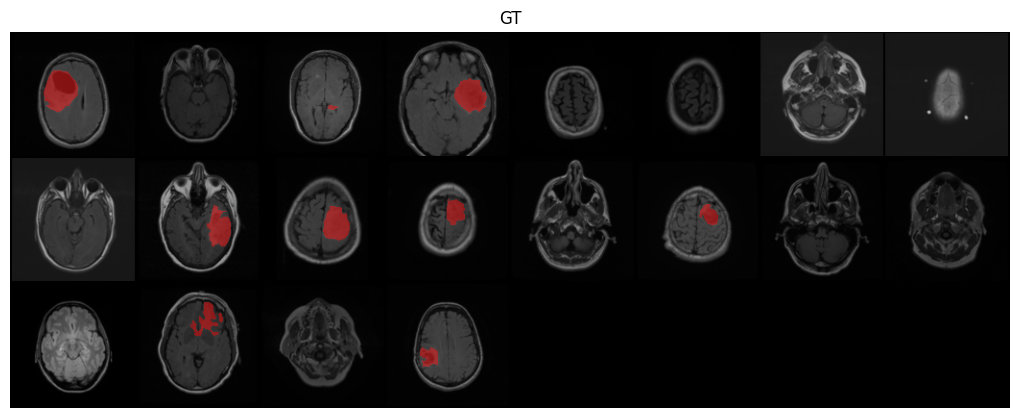

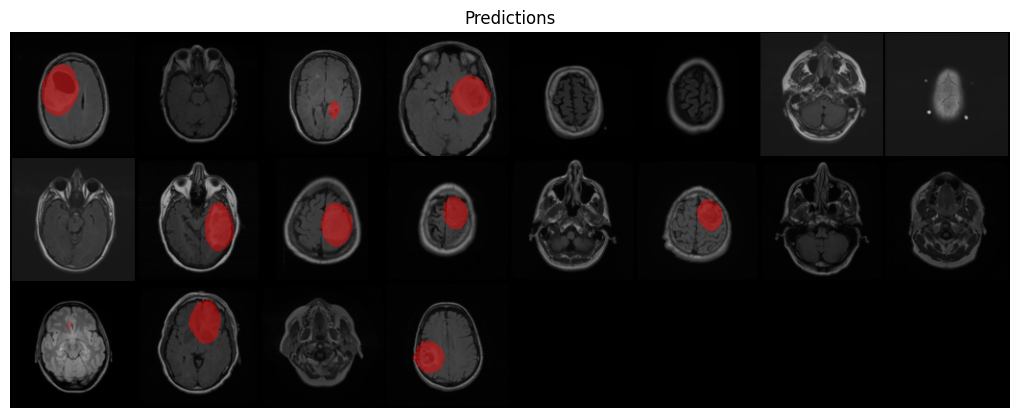

In [20]:

with torch.no_grad():
    model.eval()
    
    ds = dm.test_set

    print(len(ds))

    # show a pair (img,mask)
    samples = [ds[i] for i in range(20,40)]
    show_samples(samples,'GT')

    ys_hat = [model(s[0].unsqueeze(0)).squeeze(0) for s in samples]

    preds = [(torch.sigmoid(y_hat) > 0.5).float() for y_hat in ys_hat]


    show_samples(list(zip([s[0] for s in samples],preds)),'Predictions')


**Exercise**. Compute the number of FN (False Negatives), samples in which the model was not able to find a tumor that was present. Technically the impact of this FN is not that much since for every patient we have several images to analyze. This analysis should be done at the patient level and not at the image level.